# Lab 8 Model-Data Comparison Metrics

## Outline
[0. Import required packages](#imports)\
[1. Import data](#data_import)\
[2. Prepare data](#prep_data)\
[3. Create exploratory plots](#plots)\
[4. Fit Performance Metrics](#fit_metrics)\
[5. Event Detection Metrics](#event_metrics)

**Introducing new syntax!**\
Previously, we have accessed the columns of a `DataFrame` using `df.loc['column_name']` or simply using the shorthand `df['column_name']` omitting the implied `.loc`.

The column names of a `DataFrame` become attributes to itself, and we can access them using the dot operator. For example, we can use `df.column_name`. We will use this syntax with the dot operator exclusively throughout this Notebook. (It is my opinion that it makes the code cleaner and more readable.) Note that we can only access a single column, and the entire column, at a time using the dot, so if you want more than one column or need to select rows, you have to go back to using `.loc`.

<a id='imports'></a>
## 0. Import packages
New imports in this lab are the `interpn` function from `scipy.interpolate`, a confusion matrix from `sklearn`, and a `Rectangle` from `matplotlib`. [Read the interpn documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html), the [the confusion_matrix documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix), and the [Rectangle documentation here](https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html?highlight=rectangle#matplotlib.patches.Rectangle). 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import matplotlib.colors as mcolors
import matplotlib.dates as mdt
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix

%matplotlib inline

<a id='data_import'></a>
## 1. Import data

### 1.1 Data Description


The observed data come from OMNIWeb and are the Auroral Electrojet, Lower (AL) and Symmetric-H (SYMH) geomagnetic indices. These indices are very often used as measurements of the disturbance of Earth's magnetosphere from normal (or quiet) conditions. When the SYMH index goes very far negative ($\lesssim -$50nT) we say consider that to be a geomagnetic storm event. When the AL index goes very rapidly and far negative ($\lesssim -$200nT/10min) we might consider that we are seeing a substorm event. Both geomagnetic storms and substorms are dependent upon how the solar wind is interacting with the magnetosphere. AL and SYMH data can be obtained from either [CDAWeb](https://cdaweb.gsfc.nasa.gov/index.html/ "Public data from current and past NASA space physics missions")
or the [WDC](http://wdc.kugi.kyoto-u.ac.jp/wdc/Sec3.html "World Data Center for Geomagnetism, Kyoto").

The WINDMI model has been developed to try to predict the AL and SYMH indices based on solar wind parameter inputs. The WINDMI model can be ran and output data obtained from the [CCMC](https://ccmc.gsfc.nasa.gov/models/modelinfo.php?model=WINDMI "Community Coordinated Modeling Center").


A more detailed description of the WINDMI model is available in the following papers:\
Doxas et al., 2004 <https://doi.org/10.1109/TPS.2004.833388>\
Spencer et al., 2007  <https://doi.org/10.1029/2006JA012019>

------

The data that we will use are from a [recent publication](https://doi.org/10.1029/2018SW002067). The observed and modeled data were archived on the University of Michigan's Deep Blue repository.

Use and Access: 
This data is made available under a Creative Commons Public Domain license (CCO 1.0).

To Cite Data: 
Liemohn, M. W., et al. (2018). Model evaluation guidelines for geomagnetic index predictions [data set]. University of Michigan Deep Blue Repository. <https://doi.org/10.7302/Z25T3HQC>


### 1.2 Data Format

Our data are stored as ascii text files. We've opened files of this type many times in previous labs. In one of our files, we have two columns that contain information about the date/time. We wish to read this in as a single column.

The separator (`sep`) used to parse this file is a Regular Expression.\
The meaning of `sep=' {2,}'` below is to look for a space that repeats at least 2 times. In this way, we will read the entire date-time 
information as a single column, since they are separated by a single space.

For more on Regular Expressions, see:
https://docs.python.org/3/howto/regex.html?highlight=regex

There are a lot of uses other than this for using Regular Expressions, such as finding key phrases or matching patterns of data.

In [2]:
# Use numpy open, read, and store the data into a DataFrame.
observed_data_filename = "./Data/omni_hro_1min_2014.txt"
modeled_data_filename = "./Data/windmi_newell_al_dst_2014.txt"


# Using a Regular Expression requires use of the 'python' parsing engine.
omni_data = pd.read_csv(observed_data_filename,
                        sep=' {2,}',
                        header=None,
                        names=['Datetimes', 'AL', 'SYMH'],
                        skiprows=64,
                        index_col=False,
                        engine='python')
                             
# The windmi data is in a more straightforward format.
# Here, '\s+' means any whitespace.
windmi_data = pd.read_csv(modeled_data_filename,
                          sep='\s+', # this is a regular expression that means "any whitespace"
                          header=0,
                          index_col=False,
                          comment='[')



# Let's print the first and last rows of our imported data to make sure that we 
# read the entire year of 2014.
print('Observed:\n', omni_data.head(2), '\n', omni_data.tail(2))
print('\nModeled:\n', windmi_data.head(2), '\n', windmi_data.tail(2))

Observed:
                  Datetimes  AL  SYMH
0  01-01-2014 00:00:00.000  -7    -1
1  01-01-2014 00:01:00.000  -7    -1 
                       Datetimes  AL  SYMH
525598  31-12-2014 23:58:00.000  -6    -8
525599  31-12-2014 23:59:00.000  -5    -8

Modeled:
    Year  Month  Day  Hour  Minute  Second   Time    Dst     AL
0  2014      1    1     0       0       0  86400 -15.62 -115.6
1  2014      1    1     0       1       0  86460 -15.62 -116.0 
         Year  Month  Day  Hour  Minute  Second     Time    Dst     AL
525598  2014     12   31    23      58       0  1987080 -21.98 -84.41
525599  2014     12   31    23      59       0  1987140 -21.96 -84.03


<a id='prep_data'></a>
## 2. Prep Data

As we have done with previous data, we will combine the date and time columns into a single datatype of `datetime`, and then set that as the index for our DataFrames.

In [3]:
omni_dt_col = 'Datetimes'
windmi_dt_cols = ['Year', 'Month', 'Day', 'Hour',
                  'Minute', 'Second']

# We need to specify the format for our Datetime column.
omni_datetimes = pd.to_datetime(omni_data.loc[:,omni_dt_col],
                                infer_datetime_format=False,
                                format="%d-%m-%Y %H:%M:%S.%f")


# Since all of the windmi columns are labeled with what part of the
# datetime they represent, we will let Pandas infer the format for us.
windmi_datetimes = pd.to_datetime(windmi_data[windmi_dt_cols])

# This line is unnecessary, but included to keep the two datetime Indices consistent.
windmi_datetimes.name = omni_dt_col


# Let's print a few entries to make sure it worked correctly.
print(omni_datetimes[:5])
print('\n', windmi_datetimes[:5])

0   2014-01-01 00:00:00
1   2014-01-01 00:01:00
2   2014-01-01 00:02:00
3   2014-01-01 00:03:00
4   2014-01-01 00:04:00
Name: Datetimes, dtype: datetime64[ns]

 0   2014-01-01 00:00:00
1   2014-01-01 00:01:00
2   2014-01-01 00:02:00
3   2014-01-01 00:03:00
4   2014-01-01 00:04:00
Name: Datetimes, dtype: datetime64[ns]


It looks like our parsing worked. We will set these datetimes to be the Index for both DataFrames. In the process of setting the Index, we will drop the date/time columns from the DataFrames, since all of that information is now contained in the Index.

In [4]:
# Setting the index. Note that omni and windmi datetimes are identical.
omni_data.set_index(omni_datetimes, inplace=True)
windmi_data.set_index(windmi_datetimes, inplace=True)

# Dropping no longer needed columns.
omni_data.drop(omni_dt_col, axis=1, inplace=True)
windmi_data.drop(windmi_dt_cols + ['Time'], axis=1, inplace=True)

# While here, we will rename 'Dst' to 'SYMH' for consistency between
# the two datasets.
windmi_data.rename(mapper={'Dst':'SYMH'}, axis=1, inplace=True)


# And a quick check that our DataFrames are how we expect.
print('Observed:\n', omni_data.head(2))
print('\nModeled:\n', windmi_data.head(2))

Observed:
                      AL  SYMH
Datetimes                    
2014-01-01 00:00:00  -7    -1
2014-01-01 00:01:00  -7    -1

Modeled:
                       SYMH     AL
Datetimes                        
2014-01-01 00:00:00 -15.62 -115.6
2014-01-01 00:01:00 -15.62 -116.0


#### Finally, let's make sure that our two datasets have the same number of entries.

In [5]:
omni_data.shape == windmi_data.shape

True

<a id='plots'></a>
## 3. Create exploratory plots

### 3.1 Plotting the observed versus modeled as scatter

We can use simple scatter plots to see how well the modeled values compare to the observed values.

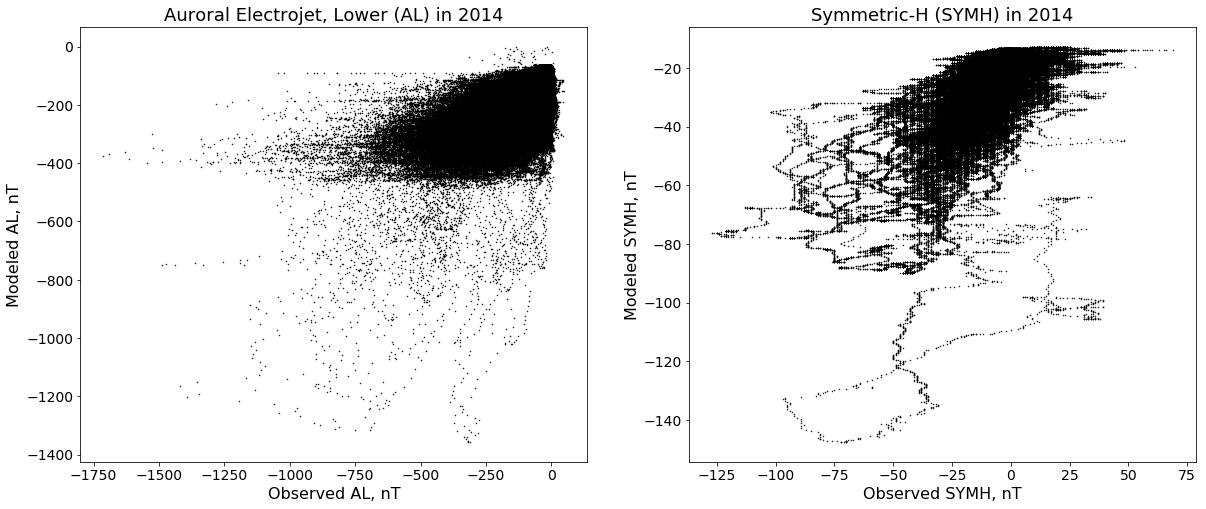

In [6]:
fig, (ax_AL, ax_SYMH) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))


# The columns of a DataFrame become part of it's attributes, and we can access them
# using the dot operator.
ax_AL.plot(omni_data.AL, windmi_data.AL,
           ls='', 
           marker='.',
           ms=1,
           color='k')


ax_SYMH.plot(omni_data.SYMH, windmi_data.SYMH, 
             ls='', 
             marker='.',
             ms=1,
             color='k')


# Set labels.
ax_AL.set_ylabel('Modeled AL, nT', fontsize=16)
ax_AL.set_xlabel('Observed AL, nT', fontsize=16)
ax_AL.set_title('Auroral Electrojet, Lower (AL) in 2014', fontsize=18)
ax_AL.tick_params(labelsize=14)


ax_SYMH.set_ylabel('Modeled SYMH, nT', fontsize=16)
ax_SYMH.set_xlabel('Observed SYMH, nT', fontsize=16)
ax_SYMH.set_title('Symmetric-H (SYMH) in 2014', fontsize=18)
ax_SYMH.tick_params(labelsize=14)

These plots are informative, but we can do better. We should change the axes so that they are on the same scale at a minimum.

What is also less than transparent is the density of black dots where they are all overlapping. We will fix this next with a density colormap, or heatmap. For this, we will use an interpolation over the points to find an interpolated density of points. *Note that there is more than one way to obtain such a plot.* This may take a minute or so to run.

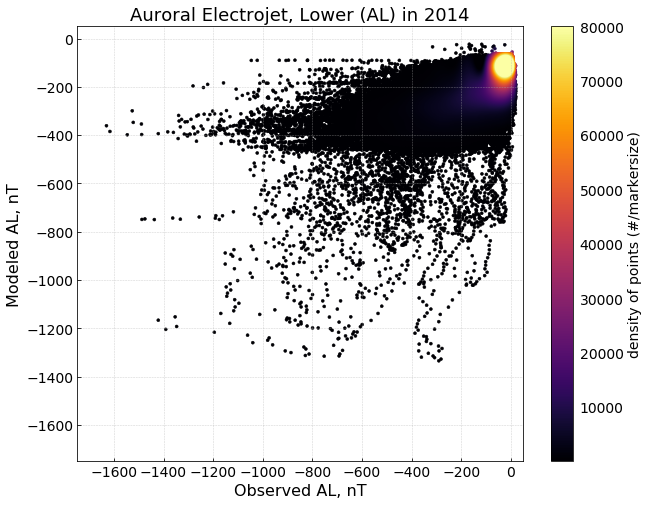

In [7]:
# We will show an example using the AL index data and model output.
fig, ax_AL = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

# omni_data.AL returns the column with name "AL" from the omni_data DataFrame
x, y = omni_data.AL, windmi_data.AL


# First we will set up a 2 dimensional histogram.
hist2d, x_edges, y_edges = np.histogram2d(x, y, bins=[30, 30])

# Then we will interpolate over the values of the 2d histogram to make a z-component
# The interpn function interpolates between points. The 
z = interpn( ( 0.5 * (x_edges[1:] + x_edges[:-1]), 
               0.5 * (y_edges[1:] + y_edges[:-1]) ),
            hist2d, np.vstack([x, y]).T, 
            method="splinef2d",
            bounds_error=False)

# We organize the values so that they are aligned with our z-component.
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Finally, this creates the scatter plot, 
# and we color each point with it's corresponding "z" value.
sctr = ax_AL.scatter(x, y, c=z, cmap='inferno',  #Use _r to reverse any colormap, e.g. inferno_r
                     vmin=1, vmax=8e4,  # Setting minimum and maximum color values.
                     marker='.', 
                     #norm=mcolors.LogNorm(), #optional, instead of vmin, vmax
                     linewidths=0.5)
                     
# Create a colorbar and colorbar label.
cbar = plt.colorbar(sctr, ax=ax_AL)
cbar.ax.set_ylabel('density of points (#/markersize)', fontsize=14)
cbar.ax.tick_params(labelsize=14, right=False)


# Standardize the x, y scales
low, high = -1750, 50
ax_AL.set_xlim(low, high)
ax_AL.set_ylim(low, high)


# Set labels, as before.
ax_AL.set_ylabel('Modeled AL, nT', fontsize=16)
ax_AL.set_xlabel('Observed AL, nT', fontsize=16)
ax_AL.set_title('Auroral Electrojet, Lower (AL) in 2014', fontsize=18)
ax_AL.tick_params(labelsize=14, which='both', direction='in')

ax_AL.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

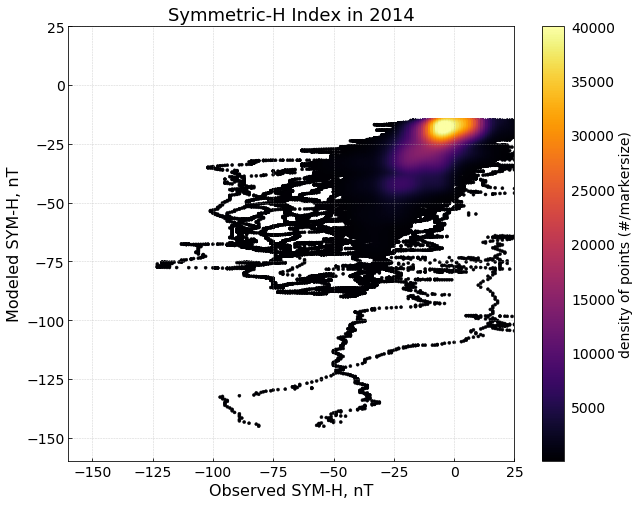

In [8]:
# And the same example except using the SYM-H data.
fig, ax_SYMH = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))


x, y = omni_data.SYMH, windmi_data.SYMH


# First we will set up a 2 dimensional histogram.
hist2d, x_edges, y_edges = np.histogram2d(x, y, bins=[30, 30])

# Then we will interpolate over the values of the 2d histogram to make a z-component
# The interpn function interpolates between points. The 
z = interpn( ( 0.5 * (x_edges[1:] + x_edges[:-1]), 
               0.5 * (y_edges[1:] + y_edges[:-1]) ),
            hist2d, np.vstack([x, y]).T, 
            method="splinef2d",
            bounds_error=False)

# We organize the values so that they are aligned with our z-component.
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Finally, this creates the scatter plot, 
# and we color each point with it's corresponding "z" value.
sctr = ax_SYMH.scatter(x, y, c=z, cmap='inferno',  #Use _r to reverse any colormap, e.g. inferno_r
                       vmin=1, vmax=4e4,  # Setting minimum and maximum color values.
                       marker='.',
                       #norm=mcolors.LogNorm(), #optional, instead of vmin, vmax
                       linewidths=0.5)
                     
# Create a colorbar and colorbar label.
cbar = plt.colorbar(sctr, ax=ax_SYMH)
cbar.ax.set_ylabel('density of points (#/markersize)', fontsize=14)
cbar.ax.tick_params(labelsize=14, right=False)

# Standardize the x, y scales
low, high = -160, 25
ax_SYMH.set_xlim(low, high)
ax_SYMH.set_ylim(low, high)

# Set labels, as before.
ax_SYMH.set_ylabel('Modeled SYM-H, nT', fontsize=16)
ax_SYMH.set_xlabel('Observed SYM-H, nT', fontsize=16)
ax_SYMH.set_title('Symmetric-H Index in 2014', fontsize=18)
ax_SYMH.tick_params(labelsize=14, which='both', direction='in')

ax_SYMH.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)


If we change the colorscale above to be logNorm, then we can see more details in the variations. Feel free to explore this by uncommenting the line `norm=mcolors.LogNorm(),` in the above code blocks.\
Plotting the scatter of model/data comparison in this way allows us to see more features of the comparison than simply making a blob of points that are too close together to visually separate. For example, we see right away that the vast majority of points are occuring when both SYM-H and AL are close to zero. We also can see that for the SYM-H especially, the model predicts no values larger than about -15 nT, but we can see that there is a lot of observed values greater than -15 nT. 

### 3.2  Plotting as Time series

**We can also plot these data as a time series, which we will do next.** We have conveniently saved the time and date of these observations as a DatetimeIndex to our DataFrames. Each item in the DatetimeIndex is a datetime object.

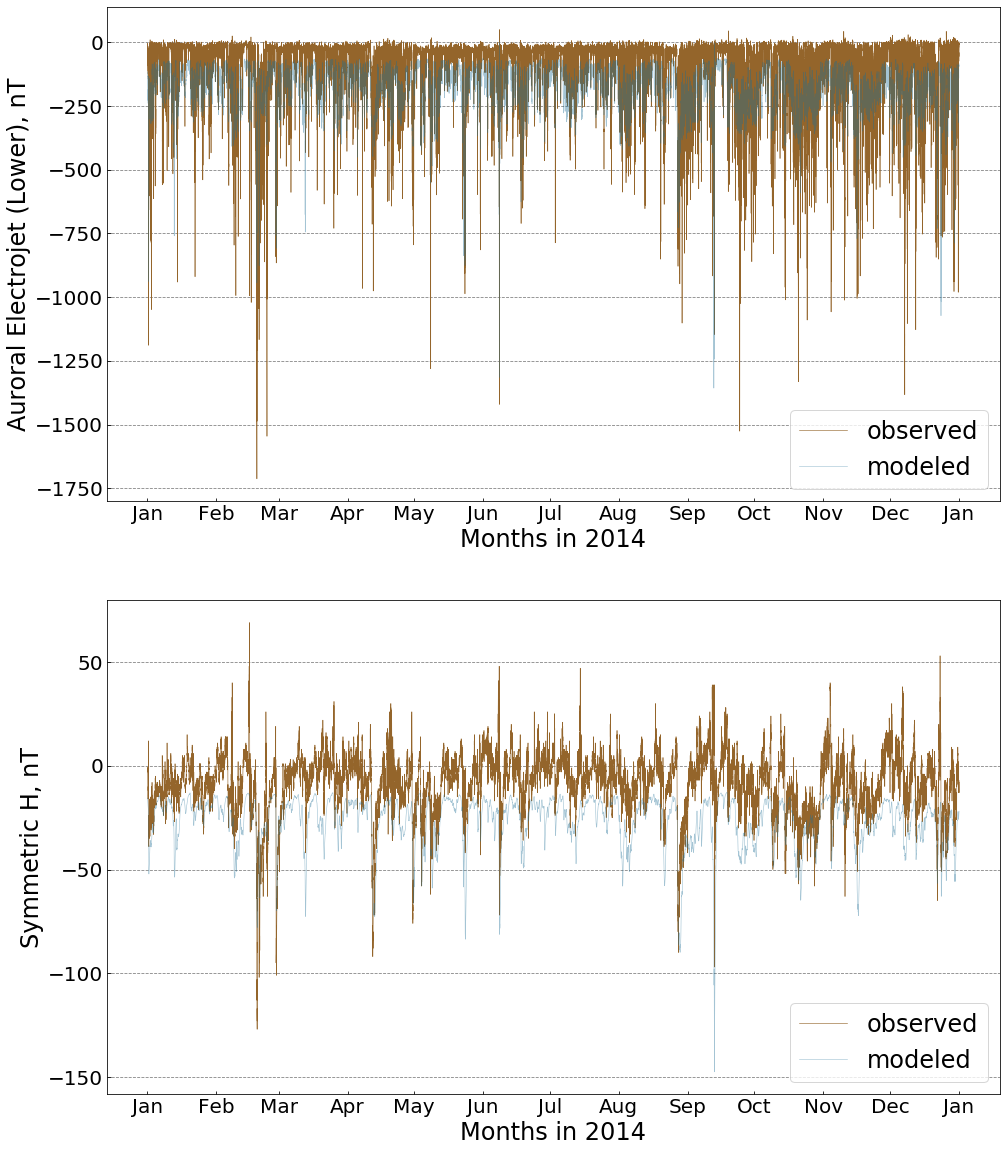

In [14]:
# We will choose which colors to use for our modeled and observed data.
observed_color, modeled_color = '#94652b', '#1c6d94'


# Set up our figure.
fig, (ax_AL, ax_SYMH) = plt.subplots(nrows=2, ncols=1, figsize=(16, 20))



# Plot both the observed and modeled data on same axes.
ax_AL.plot(omni_data.index, 
           omni_data.AL, 
           color=observed_color, 
           lw=0.6,
           label='observed')

ax_AL.plot(windmi_data.index,
           windmi_data.AL,
           color=modeled_color,
           lw=0.6,
           alpha=0.4, # notice how we use this to show both data sets
           label='modeled')

# We can create a legend, and improve labels, as appropriate.
ax_AL.legend(loc='lower right', fontsize=24)
ax_AL.set_xlabel('Months in 2014', fontsize=24)
ax_AL.set_ylabel('Auroral Electrojet (Lower), nT', fontsize=24)
ax_AL.tick_params(which='both', direction='in', labelsize=20)

# Let's also set up our horizontal axis to display the dates
# in a format that we want.
ax_AL.xaxis.set_major_locator(mdt.MonthLocator())
ax_AL.xaxis.set_major_formatter(mdt.DateFormatter('%b'))

ax_AL.grid(True, axis='y', color='gray', ls='--')

# ------------------------------- #
# We do the same for the SYMH plot.
# Plot both the observed and modeled data on same axes.
ax_SYMH.plot(omni_data.index, 
             omni_data.SYMH, 
             color=observed_color, 
             lw=0.6,
             label='observed')

ax_SYMH.plot(windmi_data.index,
             windmi_data.SYMH,
             color=modeled_color,
             lw=0.6,
             alpha=0.4, # notice how we use this to show both data sets
             label='modeled')

# We can create a legend, and improve labels, as appropriate.
ax_SYMH.legend(loc='lower right', fontsize=24)
ax_SYMH.set_xlabel('Months in 2014', fontsize=24)
ax_SYMH.set_ylabel('Symmetric H, nT', fontsize=24)
ax_SYMH.tick_params(which='both', direction='in', labelsize=20)

# Let's also set up our horizontal axis to display the dates
# in a format that we want.
ax_SYMH.xaxis.set_major_locator(mdt.MonthLocator())
ax_SYMH.xaxis.set_major_formatter(mdt.DateFormatter('%b'))

ax_SYMH.grid(True, axis='y', color='gray', ls='--')


<a id='fit_metrics'></a>
## 4. Fit Performance Metrics

[4.1 Stand Alone](#stand_alone)\
[4.2 Subsetting - Discrimination & Reliability](#subsetting)\
[4.3 Comparison](#comparison)

<a id='stand_alone'></a>
### 4.1 Stand Alone

[4.1.1 Accuracy](#accuracy)\
[4.1.2 Association](#association)\
[4.1.3 Bias](#bias)\
[4.1.4 Precision](#precision)\
[4.1.5 Extremes](#extremes)

<a id='accuracy'></a>
#### 4.1.1 Accuracy

We can calculate Accuracy using the quadrature error, or Root-Mean-Squared-Error (RMSE), between the model and observed values. We have seen RMSE several times before in the previous labs. It is defined as

$$ \textrm{RMSE} = \sqrt{\frac{1}{N-m} \sum_{i=1}^N \left(y_i - M_i \right)^2} $$

where $M_i$ and $y_i$ are the model and observed values at $x_i$, respectively, $m$ is the degrees of freedom of the fit, $N$ is the number of observations. Note, if $N>>m$, then $N-m \approx N$.

We can also calculate Accuracy with the Mean Absolute Error (MAE).

$$ \textrm{MAE} = \frac{1}{N}\sum_{i=1}^N |y_i - M_i | .$$


------
**A brief review of functions and different calling styles.**

With functions, we can use default values for parameters, like in the `calc_MSE` function below. `m=0` unless a specific value is passed for `m` during the function call. You might have noticed a *lot* of such default parameter values when looking at documentation for pandas and numpy functions.

We can also write functions that call other user-defined functions using some or the all of the same parameters. We do this with `calc_RMSE` below. 

Another useful input parameter feature for functions is using optional parameters. We use an example in the `calc_MAE` function below. Here, `N=None` in the parameter list, and in the function definition, we will either use the `N` value or not, depending on if the user passed a value for it. Typically, you will see something like
    
    if N is not None:
        #do something with N
        
in the function definition. We will be doing the opposite; that is, if the user passed us an `N`, we do not want to change it.

In [10]:
def calc_MSE(y, M, m=0):
    """
    Calculate the Mean Squared Error between observations *y* and 
    model predictions *M*. 
    
    MSE is defined as the sum of squared residuals divided 
    by the number of compared points.
    """
    # The zeroeth entry of the shape attribute is the number of rows.
    N = y.shape[0]
    
    # The sum of squared residuals
    ssr = np.sum( (y - M)**2 )
    
    return ssr / (N-m)
    

def calc_RMSE(y, M, m=0):
    """
    Calculate and return the RMSE between observations *y* and
    model predictions *M*.
    """
    
    # The y, M, m that are passed to calc_RMSE are used in the 
    # calc_MSE function. 
    # Then, we take the square root of that result and return it. 
    return np.sqrt(calc_MSE(y, M, m))


def calc_MAE(y, M, N=None):
    """
    Calculate and return the MAE between observations *y* and 
    model predictions *M*.
    """
    # We need to find the number of observations. The user might
    # have already told us what N they want to use.
    if N is None:
        N = y.shape[0]
    else:
        pass
        # pass means: go to the next line of code to be executed.
        # We really don't need this else statement, but included it
        # for completeness. We don't want to do modify N 
        
    # Find the sum of absolute differences.
    sad = np.sum(np.abs(y - M))
    
    return sad / N
   

Now that we have our functions for calculating Accuracy, let's see the accuracy of the WINDMI model.

In [11]:
# Calling the function with/without defaults.
windmi_AL_rmse = calc_RMSE(omni_data.AL, 
                           windmi_data.AL)

windmi_SYMH_rmse = calc_RMSE(omni_data.SYMH, 
                             windmi_data.SYMH, 
                             2)


# Calling the functino with/without optional parameter.
windmi_AL_mae = calc_MAE(omni_data.AL, 
                         windmi_data.AL)

windmi_SYMH_mae = calc_MAE(omni_data.SYMH, 
                           windmi_data.SYMH, 
                           omni_data.shape[0])

In [12]:
# print out the AL accuracies
print("WINDMI AL MAE:    {:>8.4f} nT".format(windmi_AL_mae))
print("WINDMI AL RMSE:   {:>8.4f} nT".format(windmi_AL_rmse))
print("OMNI AL std:      {:>8.4f} nT".format(omni_data.AL.std()))
print("WINDMI AL std:    {:>8.4f} nT".format(windmi_data.AL.std()))

print()

# print out the SYMH accuracies
print("WINDMI SYMH MAE:  {:>8.4f} nT".format(windmi_SYMH_mae))
print("WINDMI SYMH RMSE: {:>8.4f} nT".format(windmi_SYMH_rmse))
print("OMNI SYMH std:    {:>8.4f} nT".format(omni_data.SYMH.std()))
print("WINDMI SYMH std:  {:>8.4f} nT".format(windmi_data.SYMH.std()))

WINDMI AL MAE:    107.8118 nT
WINDMI AL RMSE:   126.5829 nT
OMNI AL std:      120.6986 nT
WINDMI AL std:     88.4328 nT

WINDMI SYMH MAE:   18.2670 nT
WINDMI SYMH RMSE:  20.8570 nT
OMNI SYMH std:     14.4438 nT
WINDMI SYMH std:   12.1188 nT


**Do these values show good Accuracy?**\
How can you tell?

We leave it as an exercise to you to calculate the Normalized RMSE (nRMSE) using whichever normalization ($\Delta$) you choose.

$$ \textrm{nRMSE} = \frac{1}{\Delta} \, \textrm{RMSE} $$

In [ ]:
# Compare different normalizations. 
# Note, you can easily get IQR with a DataFrame using .quantile()
#iqr = omni_data.AL.quantile(.75) - omni_data.AL.quantile(.25)

delta_AL = ? #omni_data.AL.std()? IQR? something else?
delta_SYMH = ? #omni_data.SYMH.quantile(.5)?

nrmse_AL = ?
nrmse_SYMH = ?

print(?)

<a id='association'></a>
#### 4.1.2 Association

We have seen a common Association value in the linear fit labs. When we used `scipy.stats.linregress` to calculate a linear fit, one of the returned values was the Pearson correlation coefficient (CC).

We can also use `scipy.stats.pearsonr` to directly calculate the Pearson CC, and `scipy.stats.spearmanr` for the Spearman Rank Correlation.

In [15]:
pearson_r, pval_pearsonr = stats.pearsonr(omni_data.AL, 
                                          windmi_data.AL)

spearman_r, pval_spearmanr = stats.spearmanr(omni_data.AL,
                                             windmi_data.AL)

In [16]:
print("Pearson:  {:.3f}   pval: {:.3e}".format(pearson_r,
                                               pval_pearsonr))

print()

print("Spearman: {:.3f}   pval: {:.3e}".format(spearman_r,
                                               pval_spearmanr))


Pearson:  0.656   pval: 0.000e+00

Spearman: 0.637   pval: 0.000e+00


A returned p-value of zero means that the p-value was numerically equivalent to zero. This is not surprising since the CCs are fairly large and we have $\mathrm{N}\gg1$.

<a id='bias'></a>
#### 4.1.3 Bias

For Bias, we will calculate the Mean Error (ME). 

$$ \textrm{ME} = \bar{M} - \bar{y} $$

where $M$ and $y$ are the model and observations, respectively. Remember that sign matters!

In [17]:
def calc_ME(y, M, M_minus_y=True):
    """
    Calculate and return the mean error between observations, *y* and 
    modeled data, *y*.
    
    If *M_minus_y* is True (default) then the ME is calculated as 
    mean(M) - mean(y). Opposite if False.
    
    """
    mean_M = np.mean(M)
    mean_y = np.mean(y)
    
    if M_minus_y:
        return mean_M - mean_y
    
    else:
        return mean_y - mean_M

In [18]:
bias_SYMH = calc_ME(omni_data.SYMH, windmi_data.SYMH)
bias_AL = calc_ME(omni_data.AL, windmi_data.AL)

print("SYMH Bias: {:.3f} nT".format(bias_SYMH))
print("AL Bias:   {:.3f} nT".format(bias_AL))

SYMH Bias: -17.606 nT
AL Bias:   -87.430 nT


We saw in the plots that for both AL and SYMH, the WINDMI model seemed to have a ceiling that was below the maximum observed values. 

*Is what we saw in the comparison plots reflected in the Bias calculation? Why or why not?*

*How large is the Bias?* (What would you compare the calculated bias to tell if it is large?)

<a id='precision'></a>
#### 4.1.4 Precision

The Precision metric attempts to answer the question: *Do the model and observed values have the same clustering?*

Calculating precision can be quite simple. We will define a single function to return both $P_\sigma$ and $P_r$, the precision based on standard deviations and ranges, respectively.

$$ P_\sigma = \sigma_M - \sigma_y $$
$$ P_r = [\max(M) - \min(M)] - [\max(y) - \min(y)] $$


In [19]:
def calc_precision(y, M, M_before_y=True):
    """
    Calculate and return the precision based on standard deviation
    and the precision based on differencing ranges given
    *y* observed values, and
    *M* modeled values.
    
    If *M_before_y* is True (default), then subtract the observed data 
    stats from the modeled data stats.
    
    returns:
    p_sigma, p_r
    
    """
    # Calculate p_sigma, with condition that M_before_y is True.
    p_sigma = np.std(M) - np.std(y)
    
    # Find the ranges of the data.
    m_range = M.max() - M.min()
    y_range = y.max() - y.min()
    
    # Calculate p_r, with condition that M_before_y is True.
    p_r = m_range - y_range
    
    if M_before_r:
        return p_sigma, p_r
    
    else:
        return -p_sigma, -p_r
    

We will leave it to you to use the above function and interpret it's calculation.

In [ ]:
#TODO: use calc_precision to calculate the precision of both the
#      AL and SYMH WINDMI models.
#      Answer the question: Does the model spread underestimate or
#      overestimate the data spread?

# How do the precision metrics compare with the standard deviations 
# of the observed and the modeled data? Why should we compare it with
# these values?

symh_psigma, symh_pr = ?
??





print(??)
#

<a id='extremes'></a>
#### 4.1.5 Extremes

With the extremes metric, we are trying to see how well the model can predict outliers in the observed data. Some available tools for this we have already seen in other labs.

Using *skew* ($\gamma$) and *kurtosis* ($k$), we can calculate:

$$ \gamma_\Delta = \gamma_M - \gamma_y $$
$$ k_\Delta = k_M - k_y. $$



##### 4.1.5.1 Cumulate Probability Distributions

Another useful method for examining Extremes is to use a Cumulative Probability Distribution, also called a Cumulative Density Function (CDF). For every point, $x$ of some Probability Distribution Fuction (PDF), the value of the CDF is the cumulative area of the PDF up to that point $x$. That is, a CDF is the integration of the PDF. Mathematically, it looks like this:

$$ \mathrm{F}(x) = \int_{-\infty}^{x} \mathrm{f}(t)\,\mathrm{d}t .$$

where $\mathrm{F}$ is the CDF and $\mathrm{f}$ is the PDF. For example, if $\mathrm{f}$ is a Gaussian with $\mu=0$ and $\sigma=1$, then we have:

$$ \mathrm{F}(x) = \int_{-\infty}^{x} \frac{1}{\sqrt{2\pi}}e^{-\frac{t^2}{2}}\,\mathrm{d}t .$$

Upon integration, we find,

$$ \mathrm{F}(x) = \frac{1}{2}\left( 1 + \mathrm{erf}\left(\frac{x}{\sqrt{2}} \right) \right). $$

Does this look familiar? (This is where the p-values of the $z$-table are from.) If this is starting to look complicated, don't worry. The developers of `scipy` have already written functions that will return both the PDF and CDF for the Gaussian distribution (and [many, many others](https://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html#continuous-distributions "list of scipy.stats continuous distributions")) in a single line. 

**Next, we will demonstrate how to use these `scipy` functions.**

In [21]:
# We can easily create a normal distribution, plot the histogram,
# and the Gaussian PDF. (We have seen part of this before in Lab 4.)

n = 1000
xmin, xmax = -3, 3
xvals = np.linspace(xmin, xmax, n)

# Create a random sample from a normal distribution with mean=0 and
# std=1.
norm_sample = np.random.randn(n)

# Create a pdf of the normal distribution with mean=0 and std=1.
normal_curve = stats.norm.pdf(xvals)

# To make the cdf, simply use the cdf method with the same args.
normal_cdf = stats.norm.cdf(xvals)

That's all there is. Pretty simple, right? You can use the same `.pdf` and `.cdf` on any other distribution in the same way. Let's plot what we just created.

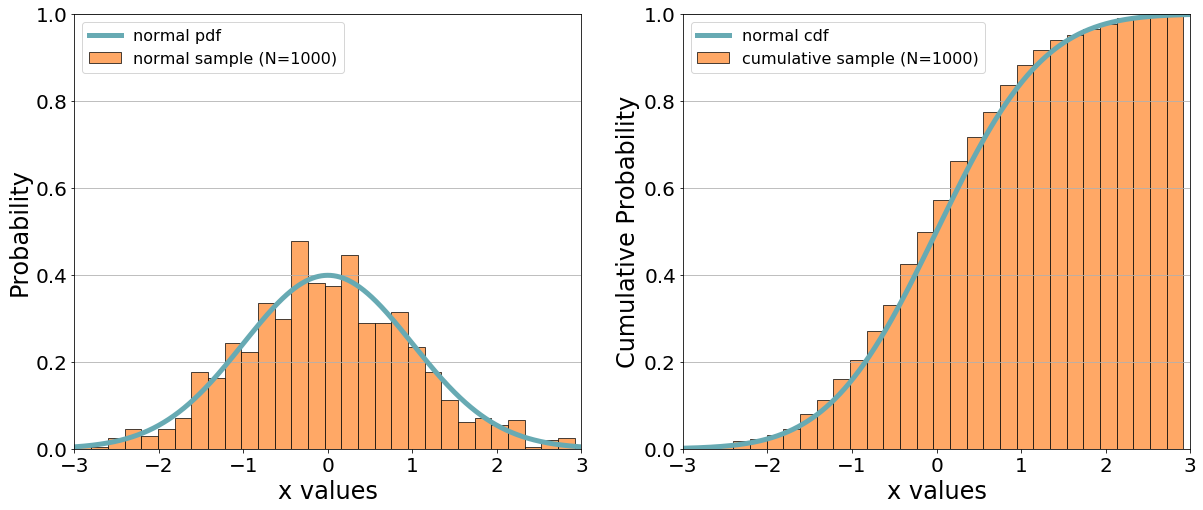

In [22]:
# Now we will plot both the histogram and the normal curve 
# on the same axes. And we will plot the CDF of both on second axes.
fig, (ax_pdf, ax_cdf) = plt.subplots(nrows=1, 
                                     ncols=2,
                                     figsize=(20, 8))

# Making the histogram. We've seen this before.
ax_pdf.hist(norm_sample, 
            bins=int(np.sqrt(n)),
            facecolor="#ffa866", 
            linewidth=0.7, 
            edgecolor='k',
            density=True,
            label='normal sample (N={})'.format(n))

# The accompanying PDF. 
ax_pdf.plot(xvals, 
            normal_curve, 
            color='#67aab3',
            lw=5,
            label='normal pdf')


# Set our x-axis and y-axis limits:
ax_pdf.set_xlim([xmin, xmax])
ax_pdf.set_ylim([0, 1])

# -------------- #
# And now the CDF.
ax_cdf.hist(norm_sample, 
            bins=int(np.sqrt(n)),
            facecolor="#ffa866", 
            linewidth=0.7, 
            edgecolor='k',
            density=True,
            cumulative=True,  # Set this param to True for cumulative!
            label='cumulative sample (N={})'.format(n))

ax_cdf.plot(xvals, 
            normal_cdf, 
            color='#67aab3',
            lw=5,
            label='normal cdf')

ax_cdf.set_xlim([xmin, xmax])
ax_cdf.set_ylim([0, 1])

# As always, we set up our labels...
ax_pdf.set_xlabel("x values", fontsize=24)
ax_pdf.set_ylabel("Probability", fontsize=24)
ax_pdf.legend(loc='upper left', fontsize=16),
ax_pdf.grid(True, axis='y')
ax_pdf.tick_params(labelsize=20)

ax_cdf.set_xlabel("x values", fontsize=24)
ax_cdf.set_ylabel("Cumulative Probability", fontsize=24)
ax_cdf.legend(loc='upper left', fontsize=16),
ax_cdf.grid(True, axis='y')
ax_cdf.tick_params(labelsize=20)

----
**Moving back to our Extremes metric...**

We can use cumulative histograms of both our observed, and our modeled data. For now, let's just use the AL data. (You can try it for yourself using the SYMH data.)

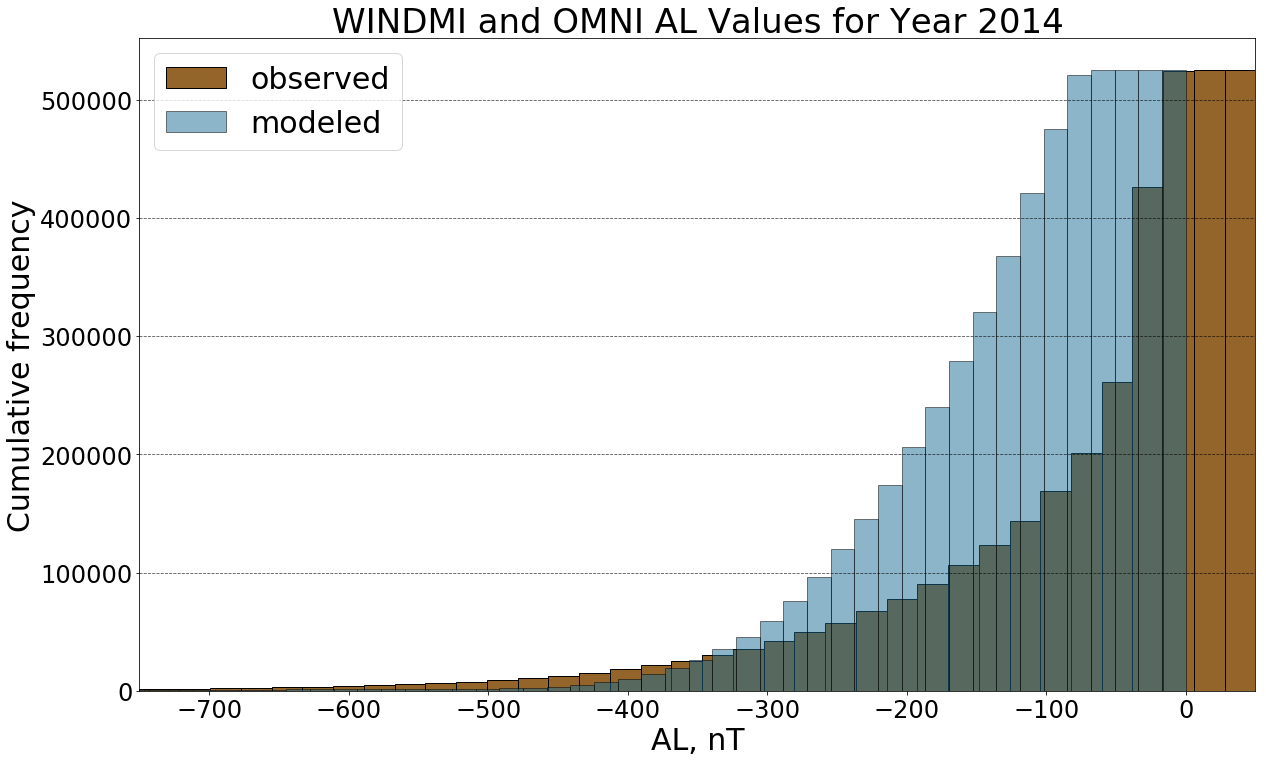

In [23]:
# We want to make sure our x-axis range covers most of the data.
xmin, xmax = -750, 50

# And we want to specify how many bins we will use.
nbins = int(np.power(omni_data.shape[0], (1/3)) )

# Let's make a plot...
fig, ax = plt.subplots(figsize=(20, 12))

ax.hist(omni_data.AL,
        bins=nbins,
        facecolor=observed_color,
        edgecolor='k',
        cumulative=True,
        label='observed')

ax.hist(windmi_data.AL,
        bins=nbins,
        facecolor=modeled_color,
        alpha=0.5,
        edgecolor='k',
        cumulative=True,
        label='modeled')

# Set up the bounds for our axis.
ax.set_xlim([xmin, xmax])

# Set up our labels.
ax.set_title("WINDMI and OMNI AL Values for Year 2014", fontsize=34)
ax.set_xlabel("AL, nT", fontsize=30)
ax.set_ylabel("Cumulative frequency", fontsize=30)
ax.legend(loc='upper left', fontsize=30)
ax.tick_params(labelsize=24)
ax.grid(axis='y', color='k', lw=0.8, ls='--', alpha=0.7)


We can also plot the above using a log scale to see more variation in the more negative values, where there are relatively few observations.

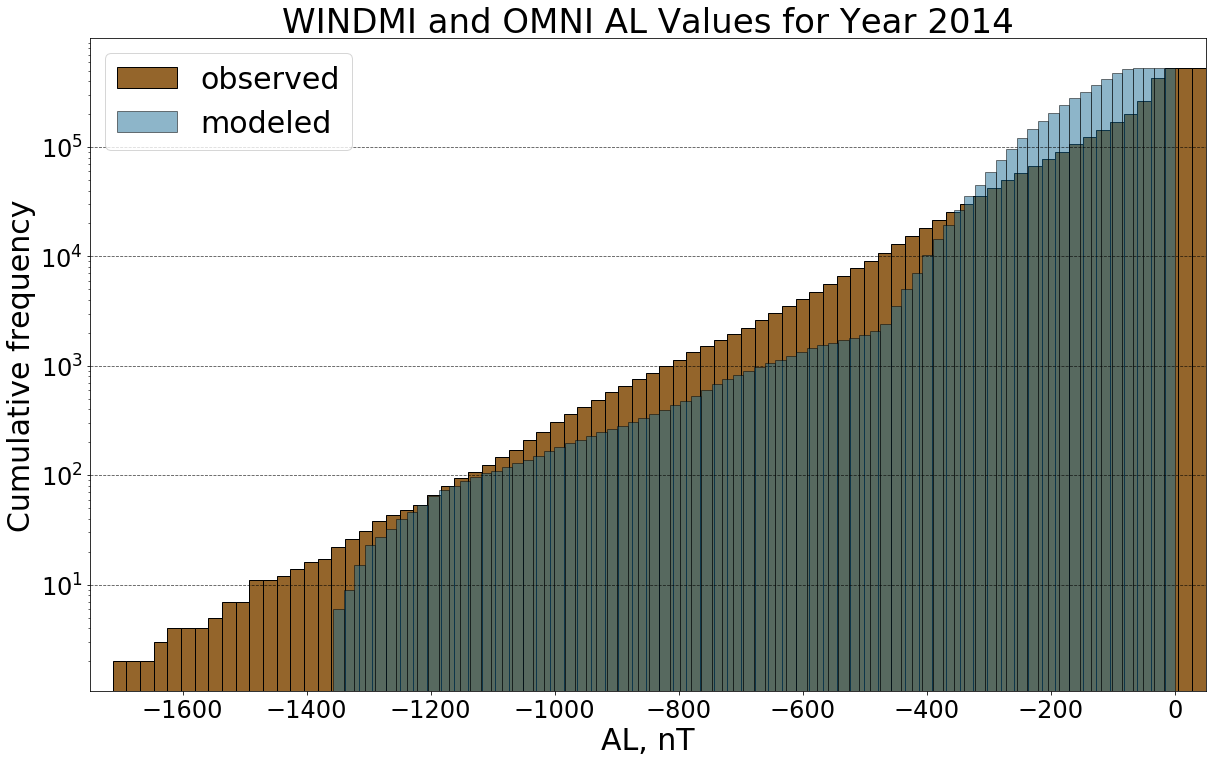

In [24]:
# We want to make sure our x-axis range covers all of the data this time.
xmin, xmax = -1750, 50

# And we want to specify how many bins we will use.
nbins = int(np.power(omni_data.shape[0], (1/3)) )

# Let's make a plot...
fig, ax = plt.subplots(figsize=(20, 12))

ax.hist(omni_data.AL,
        log=True,  # This is all we need to add to make it log scale
        bins=nbins,
        facecolor=observed_color,
        edgecolor='k',
        cumulative=True,
        label='observed')

ax.hist(windmi_data.AL,
        log=True,  # This is all we need to add to make it log scale        
        bins=nbins,
        facecolor=modeled_color,
        alpha=0.5,
        edgecolor='k',
        cumulative=True,
        label='modeled')

# Set up the bounds for our axis.
ax.set_xlim([xmin, xmax])

# Set up our labels.
ax.set_title("WINDMI and OMNI AL Values for Year 2014", fontsize=34)
ax.set_xlabel("AL, nT", fontsize=30)
ax.set_ylabel("Cumulative frequency", fontsize=30)
ax.legend(loc='upper left', fontsize=30)
ax.tick_params(labelsize=24)
ax.grid(axis='y', color='k', lw=0.8, ls='--', alpha=0.7)


What do the cumulative histograms tell us about the Extreme values between the model and the observations?

In [ ]:
#TODO: Use the cumulative histogram to examine the Extremes 
#      metric for the SYMH data.
#


#

#

<a id='subsetting' ></a>
### 4.2 Subsetting - Discrimination & Reliability

We will illustrate an example using a subset of the SYMH data. Suppose we are interested in how *reliable* the WINDMI model is in modeling the SYMH index during medium sized geomagnetic storms. Although opinions vary, we will define a medium-sized geomagnetic storm to be when $-150 nT \leq \mathrm{SYMH} \leq -100 nT$.

Since we are looking for *Reliability*, we will use a *vertical* slice of the observed-model space (where observed values are plotted along the horizontal axis, as in our scatter plots above.)

In [25]:
# First we create a boolean index that will subset our data.
# Note, "\" is a line continuation character, useful for when your
# code lines start to get too long.
medium_storm_idx = (omni_data.SYMH >= -150) & \
                   (omni_data.SYMH <= -100)
    
# Then we will use our boolean index to select only the entries
# From both observed and modeled data.
omni_medium_storm = omni_data.SYMH.loc[medium_storm_idx]
windmi_medium_storm = windmi_data.SYMH.loc[medium_storm_idx]

That's all we need to do. Now that we have our slices, we can use them in any of the above metrics we've already defined. For example, let's find the RMSE of this subset and compare it the to RMSE of the entire SYMH data.

In [26]:
medium_storm_rmse = calc_RMSE(omni_medium_storm,
                              windmi_medium_storm, 2)

print("Medium storm RMSE:  {:.3f} nT".format(medium_storm_rmse))
print("All SYMH data RMSE: {:.3f} nT".format(windmi_SYMH_rmse))

Medium storm RMSE:  43.248 nT
All SYMH data RMSE: 20.857 nT


The above result implies that the overall RMSE error is being dominated by the large number of events close to zero (the very bright spot in our heatmap above). Pick a different subset and compare the RMSE (or any other metric you wish), to the medium storm subset.

In [ ]:
#TODO: Create a boolean array to subset the observed SYMH values
#      between -20nT and 0nT.

#


# Compare the RMSE of this subset with that of a medium storm.



#

<a id="comparison" ></a>
### 4.3 Comparison

#### 4.3.1 Skill

Our general skill score formula is 

$$ SS = \frac{\text{model score } - \text{reference score}}{\text{perfect score } - \text{reference score}} $$

From this, we can derive a skill score known as Prediction Efficiency, defined as:

$$ \mathrm{PE} = 1 - \frac{\mathrm{MSE}}{\sigma^2} = 1 - \frac{\sum_{i=1}^{N} \left(y_i - M_i \right)^2}{\sum_{i=1}^{N} \left( \bar{y} - y_i \right)^2} $$

where $y_i$ is the $i$th observation and $M_i$ is the corresponding modeled value. 

**How should we interpret Prediction Efficiency?**\
Mathematically, the PE score can range from positive one to negative infinity. There is also a special value at zero. 

**PE = 1** if:\
There is zero error between the model and the observations. 


**PE = 0** if:\
The model is simply the mean of our observations (set $M_i = \bar{y}$ for all $i$).


**PE $\to -\infty$** if:\
Either MSE $\to \infty$, or $\sigma^2 \to 0$.

The closer PE is to one, the better.\
Any PE value that is negative implies that the model is performing worse than if we just guessed the observed average.

In [27]:
def calc_PE(y, M, ddof=0):
    """
    Calculate Prediction Efficiency of model, M, 
    from observations, *y*.
    
    PE is defined as 1 - MSE/Var(y)
    
    ddof is the Delta Degrees of Freedom used to calculate variance. 
    Default is 0.
    """
    
    # Here we are using our previously defined function for 
    # MSE inside of this function.
    mse = calc_MSE(y, M, ddof)
    
    return 1 - mse/np.var(y, ddof=ddof)


def general_skillscore(model_score, reference_score, perfect_score):
    """
    Returns the general skill score according to the formula:
    (model_score - reference_score) / (perfect_score - reference_score)
    
    """
    
    return (model_score - reference_score) \
           / (perfect_score - reference_score)

In [ ]:
# TODO: use the general_skillscore function with appropriate inputs
#       so that it returns a value equal to the Prediction Efficiency
# Hint: The PE is a version of a skill score, you need to find which 
#       inputs to use.

symh_PE = calc_PE(omni_data.SYMH, windmi_data.SYMH)


ref_score = ?
mod_score = ?
per_score = ?

symh_ss = general_skillscore(mod_score, ref_score, per_score)


# Will print True if inputs are correct.
print(np.isclose(symh_PE, symh_ss))

Now you should be able to create many other skill scores based just by using the correct inputs to the general skill score formula. 

<a id='event_metrics'></a>
## 5. Event Detection Metrics

### Classification Problems

We saw earlier that the RMSE of the SYMH model was different when we looked at a different subset of the data. In that case, we were actually looking at how much error there was between the model and the observations during an *event*. Our event was: the occurence of a medium sized storm.\
But suppose we cared less about how much error there was and instead just wanted to know whether our model was able to predict such an event. Although it is not exact, a typical threshold value for determining when a geomagnetic storm has occurred is when the SYMH value goes below -50 nT. 

We will also see at which threshhold the WINDMI model is best at predicting a geomagnetic storm using an ROC curve.

----


[5.1 Smoothing Data](#rolling)\
[5.2 Contingency Table](#confusion)\
[5.3 Skill Scores](#skills)\
[5.4 ROC Curve](#roc)

<a id='rolling' ></a>
### 5.1 Smoothing Data
Geomagnetic storms last several days, and we have data with a frequency of one minute. We might want to reduce the amount of spikiness in our data, seen in the time series plots that we made above. This will help to reduce the chance that our model predicted a storm (was below -50 nT) when an actual storm occured, but might have mistimed it by a few hours. For this, we will use a convenient method of DataFrames called `rolling()`. The `rolling` method creates a sliding window of our data, from which we can calculate different quantities, like a sliding mean or median. We create a rolling object by specifying the width of our window. 

Let's choose a 2 day sliding window. Because our index is a DatetimeIndex, we can use a time frequency. Pandas has a list of offset aliases, or frequency codes, to use. For example, 'H' means hourly. If we want two hours, we use '2H'; or you can combine, like '2H30T' for two hours thirty minutes (yes, 'T' means minute, confusing, I know). You can [find the full list here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases "pandas offset aliases documentation").


In [29]:
freq = '2D' # This provides a liberal window of 2 days.

# Create a rolling object
omni_symh_rolling = omni_data.SYMH.rolling(freq)

# With the rolling object, we can take a quantity. Here we use min.
# Why are we using the minimum here??
omni_symh_2d_min = omni_symh_rolling.min()

# We can combine the above two lines into one, which we do for WINDMI.
windmi_symh_2d_min = windmi_data.SYMH.rolling(freq).min()

What did we just do? Let's print some rows to see.

In [30]:
# We still have the same number of entries, but the values have 
# been taken to be the 2 day minimum of a sliding window.
print(len(omni_data.SYMH) == len(omni_symh_2d_min), '\n')

print("original data")
print(omni_data.SYMH.iloc[2000:2005])

print("\nsmoothed data")
print(omni_symh_2d_min.iloc[2000:2005])

True 

original data
Datetimes
2014-01-02 09:20:00   -19
2014-01-02 09:21:00   -19
2014-01-02 09:22:00   -20
2014-01-02 09:23:00   -20
2014-01-02 09:24:00   -20
Name: SYMH, dtype: int64

smoothed data
Datetimes
2014-01-02 09:20:00   -39.0
2014-01-02 09:21:00   -39.0
2014-01-02 09:22:00   -39.0
2014-01-02 09:23:00   -39.0
2014-01-02 09:24:00   -39.0
Name: SYMH, dtype: float64


In this example, for every point in the original data, it is replaced by the minimum value that appeared in a two day window surrounding it.

We can also plot these smoothed data as a time series, as we did before we smoothed it.

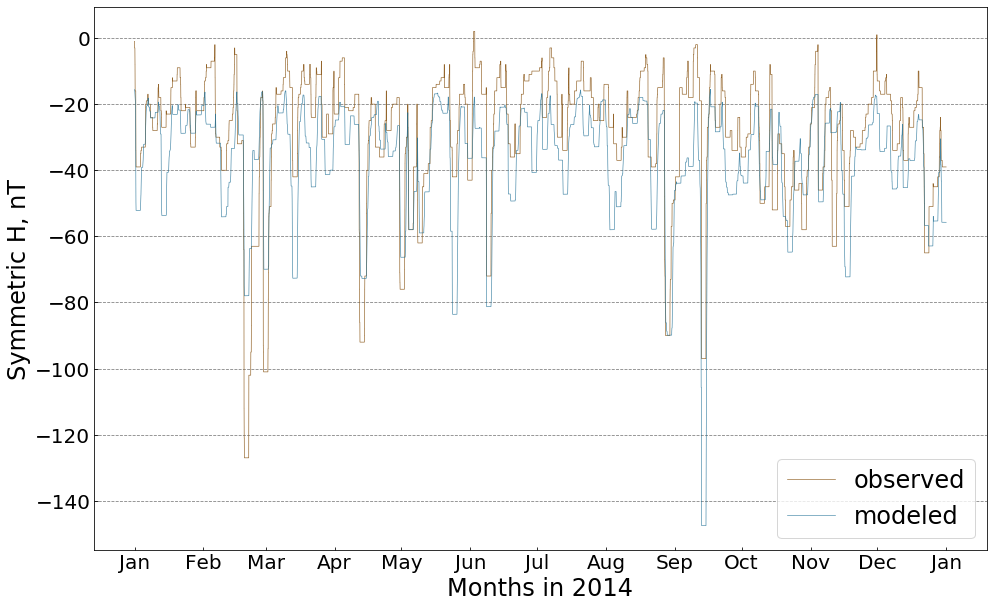

In [31]:
# Set up our figure.
fig, ax_SYMH = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))



# Plot both the observed and modeled data on same axes.
ax_SYMH.plot(omni_symh_2d_min.index, 
             omni_symh_2d_min, 
             color=observed_color, 
             lw=0.65,
             label='observed')

ax_SYMH.plot(windmi_symh_2d_min.index,
             windmi_symh_2d_min,
             color=modeled_color,
             lw=0.65,
             alpha=0.8, 
             label='modeled')

# We can create a legend, and improve labels, as appropriate.
ax_SYMH.legend(loc='lower right', fontsize=24)
ax_SYMH.set_xlabel('Months in 2014', fontsize=24)
ax_SYMH.set_ylabel('Symmetric H, nT', fontsize=24)
ax_SYMH.tick_params(which='both', direction='in', labelsize=20)

# Let's also set up our horizontal axis to display the dates
# in a format that we want.
ax_SYMH.xaxis.set_major_locator(mdt.MonthLocator())
ax_SYMH.xaxis.set_major_formatter(mdt.DateFormatter('%b'))

ax_SYMH.grid(True, axis='y', color='gray', ls='--')


Do these lines look "smoother" than before? They are! Scroll back up to check out the original. Plotted in this way, we can also visually see several times when the WINDMI model might have correctly predicted a storm. See the month of April, or late August/early September. Or times when WINDMI made a false prediction. See January.

<a id='confusion'></a>
### 5.2 Contingency Table

Now that we have prepped the data, we can set up a Contingency Table.

#### 5.2.1 
Set up "Events" or what we want to predict as a binary (Yes/No) Problem


In [32]:
# Set up event as -50. Anything below this is now an "event".
event_thrshld = -50

# Create a boolean array that will be True for event and False if not.
events = omni_symh_2d_min <= event_thrshld

#### 5.2.2 

Create the "Predictions" using the model data.

In [33]:
predictions = windmi_symh_2d_min <= event_thrshld

#### 5.2.3
Analyze. How good did the WINDMI do at predicting when a storm would occur?

In [34]:
# We imported the confusion_matrix from sklearn.

# The .ravel method "unwraps" this - 
true_neg, false_pos, miss, hit = \
    confusion_matrix(events, predictions).ravel()

print('True Positives: {}'.format(hit), 'False Positives: {}'.format(false_pos), '\n' 
      'False Negatives: {}'.format(miss), 'True Negatives: {}'.format(true_neg))

True Positives: 45229 False Positives: 46992 
False Negatives: 20263 True Negatives: 413116


**Take a moment to look at these numbers. How would you interpret these?**

**We can create a plot to display the information.**

Text(-125, -5, 'Misses\n(20,263)')

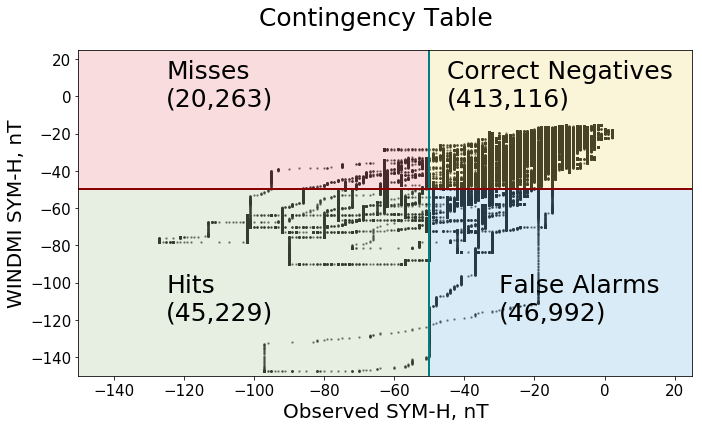

In [36]:
# Create our figure.
fig, ax = plt.subplots(figsize=(11, 6))

fig.suptitle('Contingency Table', fontsize = 25)

ax.scatter(omni_symh_2d_min, windmi_symh_2d_min, s = 2, 
           color = 'k', alpha = 0.5)


# Create view ranges.
xmin, xmax = -150, 25
# And make it square.
ymin, ymax = xmin, xmax


###################ADD PATCHES LABELING INDEX

#False Positives
# Rectangle objects work by adding the xy left of the rectangle to the width and height
# Rectangle((X, Y), width, height)
ax.add_patch(Rectangle(xy=(event_thrshld, ymin), 
                       width=xmax - event_thrshld, 
                       height=event_thrshld - ymin, 
                       alpha=0.3, facecolor = "#7fc0e4"))

# Hits
ax.add_patch(Rectangle(xy=(xmin, ymin), 
                       width=event_thrshld - xmin, 
                       height=event_thrshld - ymin, 
                       alpha=0.3, facecolor = "#b2c79f"))

#Misses
ax.add_patch(Rectangle(xy=(xmin, event_thrshld),
                       width=event_thrshld - xmin, 
                       height=ymax - event_thrshld, 
                       alpha=0.3, facecolor = "#ed9192"))


#Correct Negatives
ax.add_patch(Rectangle(xy=(event_thrshld, event_thrshld), 
                       width=xmax-event_thrshld,
                       height=ymax-event_thrshld,
                       alpha=0.3, facecolor = "#f1dc81"))

#draw boundary lines
ax.axvline(event_thrshld, color='#007f80', lw=2.0)
ax.axhline(event_thrshld, color='#8b0000', lw=2.0)

#set labels
ax.set_xlabel('Observed SYM-H, nT', fontsize=20)
ax.set_ylabel('WINDMI SYM-H, nT', fontsize=20)
ax.tick_params(labelsize=15)

#setting nice boundaries
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

#true_neg, false_pos, miss, hit
ax.annotate('False Alarms\n({:,g})'.format(false_pos), 
            xy=(event_thrshld + 20, event_thrshld - 70), 
            fontsize=25)

ax.annotate('Correct Negatives\n({:,g})'.format(true_neg),
            xy=(event_thrshld + 5, event_thrshld + 45), 
            fontsize=25)

ax.annotate('Hits\n({:,g})'.format(hit),
            xy=(event_thrshld - 75, event_thrshld - 70), 
            fontsize=25)

ax.annotate('Misses\n({:,g})'.format(miss), 
            xy=(event_thrshld - 75, event_thrshld + 45), 
            fontsize=25)


#plt.savefig('./Figures/contingency_table.png', dpi=300)

**Based off of our plot and our confusion matrix, do we think this worked well?**

### 5.3 Skill Scores

First, let's calculate two of the derivatives of this table, the Probability of Detection (POD) and the Probability of False Detection (PFD).

In [37]:
def prob_of_detect(num_true, num_false):
    """
    Will return either probability of detection or probability of false detection.
    
    """
    return num_true / (num_true + num_false)

In [38]:
windmi_pod = prob_of_detect(hit, miss)
windmi_pfd = prob_of_detect(false_pos, true_neg)

print("POD for -50nT threshold: {:.3f}".format(windmi_pod))
print("PFD for -50nT threshold: {:.3f}".format(windmi_pfd))

POD for -50nT threshold: 0.691
PFD for -50nT threshold: 0.102


**Are these values good?**\
What do they mean?

There are many other derivatives of the Contingency Table. Calculate the Miss Ratio and proportion correct below. 

In [ ]:
# TODO: Calculate the Miss Ratio and Proportion Correct based on the Contingency Table.
miss_ratio = ?
prop_correct = ?

In [ ]:
# Calculate the Heidke Skill Score.
def hss(hits, misses, false_pos, true_neg):
    """
    returns Heidke Skill Score
    
    """
    # TODO: Complete the function. Use Lecture 10 Slides.
    return ?

<a id='roc'></a>
### 5.4 ROC Curve

What if you could get a better POD and lower PFD with a different threshold?

We can vary the threshold for the model only and recalculate the Contingency Table, the POD and the PFD.

In [39]:
# Note that this cell may take a few minutes to run.
threshold_vals = np.arange(-125, 30, 1)

# Set up an empty DataFrame to capture output from performance calculations.
performance_values = pd.DataFrame({
                        'PFD' : np.zeros(len(threshold_vals)),
                        'POD' : np.zeros(len(threshold_vals))
                                  })

# Run through threshold values.
for idx, model_thrshld in enumerate(threshold_vals):
    
    # We repeat what we did to calculate the Contingency Table above, 
    # this time we will save each output into our dataframe. 
    
    # Create boolean arrays that will be True for event and False if not.
    # We will only slide over our model values, holding observed threshold constant.
    events = omni_symh_2d_min <= event_thrshld
    predictions = windmi_symh_2d_min <= model_thrshld
    
    # Use the scikit learn function to calculate our table values.
    true_neg, false_pos, miss, hit = \
        confusion_matrix(events, predictions).ravel()
    
    # Use the table values to find POD, PFD and store them in our dataframe.
    performance_values.loc[idx, 'POD'] = prob_of_detect(hit, miss)
    performance_values.loc[idx, 'PFD'] = prob_of_detect(false_pos, true_neg)

Okay, now we have an array of POD values and an array of PFD values. What should we do?\
**Plot them using an ROC Curve!**

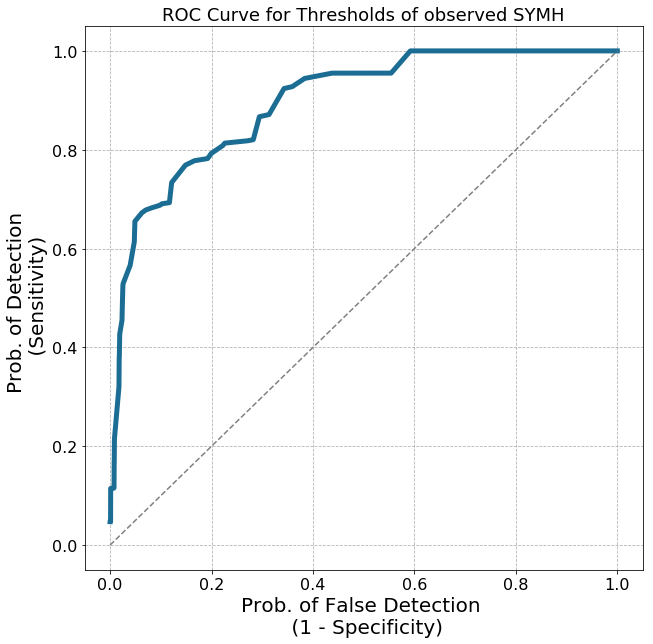

In [40]:
# Plot the ROC curve.

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title('ROC Curve for Thresholds of observed SYMH', 
             fontsize=18)

# Set up titles for axis.
ax.set_xlabel('Prob. of False Detection \n (1 - Specificity)', fontsize = 20)
ax.set_ylabel('Prob. of Detection \n (Sensitivity)', fontsize = 20)

# Plot values.
ax.plot(performance_values['PFD'], 
        performance_values['POD'],  
        color='#1c6d94', 
        lw=5.0)

# Set up "random performance line".
ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), ls = 'dashed', color = 'grey')
#set up grid
ax.grid(color='gray', linestyle='dashed', alpha=0.6)

# set nice labelsizes
ax.tick_params(labelsize=16)

**What can we say about this ROC curve? What is the significance of the dashed line? How does this change if you picked not -50 nT but rather -100 nT, what about -5? *Try it.***


**How would you vary the above code to create a STONE curve?**\
Hint: how would you also vary the observed event thresholds using the code above?

In [ ]:
# TODO: Create a STONE Curve.

# Vary both observed and modeled threshold values.


#

In [ ]:
# Plot PFD vs POD to visualize the STONE Curve


#

Using the ROC curve, to *idealize* our threshold value, we want to *minimize* the distance from the point $(0, 1)$ to our ROC curve. Below, we will show one way to do this. 

In [41]:
# Get the number of points.
num_points = performance_values.shape[0]

# Creates an array of num_points rows and two columns, every row is (0, 1).
anchor_points = np.hstack([np.zeros(num_points).reshape([num_points, 1]), 
                           np.ones(num_points).reshape([num_points, 1])])

# Find the distance row-wise using the L2 (Euclidean) norm.
# Remember how we set up the performance_values DataFrame using two columns?
# This will return an array of distances from every point in our DataFrame to 
# every point in the anchor_points array (which are all the same, (0, 1)).
distances = np.linalg.norm(anchor_points - performance_values, axis=1)

# The argmin function returns the argument (index) where the minimum value is.
min_idx = np.argmin(distances)

# The min distance. 
min_dist = np.linalg.norm(anchor_points[min_idx, :] - performance_values.iloc[min_idx, :])

# We created our array of threshold values previously.
min_thrshld = threshold_vals[min_idx]

msg = "Minimum distance from ROC to upper left corner is {:.3f}\n".format(min_dist) \
    + "and occurs for model threshold value {} nT.".format(min_thrshld)
print(msg)

Minimum distance from ROC to upper left corner is 0.275
and occurs for model threshold value -47 nT.


#### Interpretation of ideal model threshold from ROC Curve.

We found that the "best" model threshold was -47 nT for an event threshold of -50 nT. We interprete this as the model is underestimating when an event will occur. That is, in the ideal case, the model would consider an event to be whenever the -47 nT threshold is met, even though we set the event threshold at some other value (-50 nT in this case).

*Why is this useful?* One example: Suppose we will use this model in an operational setting where we wanted to simultaneously maximize our POD and minimize our PFD of geomagnetic storm events. We now know that we should pick a *model* threshold of -47 nT to forecast an event with a defined physical, or observational, threshold of -50 nT.

## Summary
In this notebook you have seen an introduction to calculating both Fit Performance Metrics and Event Detection Metrics. 

**You can now continue to develop the functions and methods used here for your next Project!**